# Correlation Analysis of Species Profiles

## Overview:

We want to see if subsampled reads can preserve information content at depths of 50K reads or lower. We do this as follows

1. Number of features detected in sequencing experiment
2. Overlap (Jaccard Index) of features detected in sequencing experiment, correlation of union of nonzero features across different depths


## Relies on:

* workflow/cmd.sh
* workflow/Snakefile.subsample_kraken2_wf
* workflow/kraken2_wf_config.yaml
* workflow/Snakefile.subsample_wf


In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jaccard
from scipy.stats import pearsonr
import os
import re
import seaborn as sns
from matplotlib import pyplot as plt

# Data Munging

In [2]:
root_dir = '/project'
top_data_dir = os.path.join(root_dir, 'workflow/results')
os.listdir(top_data_dir)

['kraken2_1K',
 'kraken2_10K',
 'kraken2_5K',
 'kraken2_100K',
 'kraken2_25K',
 'kraken2_10M',
 'kraken2_5M',
 '.gitkeep',
 'kraken2_500',
 'kraken2_1M',
 'kraken2_50K',
 'kraken2_500K']

In [3]:
data_subdirs = np.array(os.listdir(top_data_dir))
kraken2_subdirs = np.sort(data_subdirs[np.array([len(re.findall('kraken2_[0-9]+[KM]*', x)) > 0 for x in data_subdirs])])
kraken2_subdirs

array(['kraken2_100K', 'kraken2_10K', 'kraken2_10M', 'kraken2_1K',
       'kraken2_1M', 'kraken2_25K', 'kraken2_500', 'kraken2_500K',
       'kraken2_50K', 'kraken2_5K', 'kraken2_5M'], dtype='<U12')

In [4]:
kraken2_depths = []
for x in kraken2_subdirs:
    suffix = re.findall('[0-9]+[KM]*$', x)[0]
    trailing_0s = ''
    if re.search('K$', suffix):
        # 1000s of reads
        trailing_0s += '000'
    elif re.search('M$', suffix):
        # millions of reads
        trailing_0s += '000000'
    
    num_use = re.findall('[0-9]+', suffix)[0]
    kraken2_depths.append(int(num_use + trailing_0s))
    
kraken2_depths = np.array(kraken2_depths)
kraken2_depths

array([  100000,    10000, 10000000,     1000,  1000000,    25000,
            500,   500000,    50000,     5000,  5000000])

In [5]:
pipeline_metadata = pd.DataFrame({'pipeline_run': kraken2_subdirs, 'depth': kraken2_depths})
pipeline_metadata = pipeline_metadata.sort_values('depth')
pipeline_metadata

,pipeline_run,depth
6,kraken2_500,500
3,kraken2_1K,1000
9,kraken2_5K,5000
1,kraken2_10K,10000
5,kraken2_25K,25000
8,kraken2_50K,50000
0,kraken2_100K,100000
7,kraken2_500K,500000
4,kraken2_1M,1000000
10,kraken2_5M,5000000


In [6]:
def get_matrix(df):
    """
    Get a numeric matrix from data frame
    """
    matrix_cols = np.setdiff1d(df.columns.to_numpy(), ['filename', 'pipeline_run', 'run_acc', 'total_feats', 'depth'])
    mat = df.loc[:, matrix_cols].to_numpy().astype('float32')
    return mat

def get_accs(df):
    """
    Get Run Accessions from DataFrame
    """
    fastq_file_names = df['filename'].to_numpy().astype('str')
    # get run accessions. This will be important for running correlation + overlap comparisons
    run_acc = []
    for x in fastq_file_names:
        m = re.match('^[A-Z]{3}[0-9]+', x)
        if m:
            run_acc.append(m.group(0))
        else:
            raise ValueError('Unexpected run accession {}'.format(x))
            
    df['run_acc'] = np.array(run_acc)
    return df

def get_total_feats(df):
    """
    Get total number of nonzero, non-NA features
    """
    mat = get_matrix(df)
    total_feats = np.array([np.sum(mat[i, :].flatten() > 0) for i in range(mat.shape[0])])
    df['total_feats'] = total_feats
    return df

def load_file(freq_file):
    file_data = pd.read_csv(freq_file)
    file_data = get_accs(file_data)
    file_data = get_total_feats(file_data)
    
    return file_data

In [7]:
# load and merge data from all kraken2 pipeline runs
m = 0
for run in pipeline_metadata['pipeline_run']:
    fpath = os.path.join(top_data_dir, run, 'matrix/freq_mat.csv')
    loaded_df = load_file(fpath)
    # add depth to metadata
    loaded_df['depth'] = np.repeat(pipeline_metadata['depth'][pipeline_metadata['pipeline_run'] == run].to_numpy(), loaded_df.shape[0])
    # forces non-duplicate identifier. directories cannot be duplicated, nor can filenames within a directory
    loaded_df['depth_file'] = np.array([str(loaded_df['depth'][i]) + '_' + loaded_df['filename'][i] for i in range(loaded_df.shape[0])])
    melted_df = pd.melt(loaded_df, id_vars='depth_file')
    if m == 0:
        combined_melted_df = melted_df
        m += 1
    else:
        combined_melted_df = combined_melted_df.append(melted_df)
        
melted_df

,depth_file,variable,value
0,10000000_ERR2017411_seqt.subsampled_kneaddata_...,filename,ERR2017411_seqt.subsampled_kneaddata_freq_outp...
1,10000000_ERR2017412_seqt.subsampled_kneaddata_...,filename,ERR2017412_seqt.subsampled_kneaddata_freq_outp...
2,10000000_ERR2017413_seqt.subsampled_kneaddata_...,filename,ERR2017413_seqt.subsampled_kneaddata_freq_outp...
3,10000000_ERR2017414_seqt.subsampled_kneaddata_...,filename,ERR2017414_seqt.subsampled_kneaddata_freq_outp...
4,10000000_ERR2017415_seqt.subsampled_kneaddata_...,filename,ERR2017415_seqt.subsampled_kneaddata_freq_outp...
...,...,...,...
129993,10000000_ERR2017426_seqt.subsampled_kneaddata_...,depth,10000000
129994,10000000_ERR2017427_seqt.subsampled_kneaddata_...,depth,10000000
129995,10000000_ERR2017428_seqt.subsampled_kneaddata_...,depth,10000000
129996,10000000_ERR2017429_seqt.subsampled_kneaddata_...,depth,10000000


In [8]:
np.repeat(pipeline_metadata['depth'][pipeline_metadata['pipeline_run'] == run].to_numpy(), loaded_df.shape[0])

array([10000000, 10000000, 10000000, 10000000, 10000000, 10000000,
       10000000, 10000000, 10000000, 10000000, 10000000, 10000000,
       10000000, 10000000, 10000000, 10000000, 10000000, 10000000,
       10000000])

In [9]:
loaded_df['depth'] = np.repeat(3, loaded_df.shape[0])

In [10]:
combined_df = pd.pivot(combined_melted_df, index='depth_file', columns='variable', values='value')
combined_df

variable,Homo sapiens,Brassica napus,Alphamesonivirus 4,Bat Hp-betacoronavirus Zhejiang2013,Blochmannia endosymbiont of Camponotus (Colobopsis) obliquus,Blochmannia endosymbiont of Camponotus nipponensis,Blochmannia endosymbiont of Colobopsis nipponica,Blochmannia endosymbiont of Polyrhachis (Hedomyrma) turneri,Candidatus Aquiluna sp. 15G-AUS-rot,Candidatus Aquiluna sp. UB-MaderosW2red,...,endophytic bacterium LOB-07,uncultured bacterium,Aedes camptorhynchus negev-like virus,Mollivirus sibericum,Pacmanvirus A23,uncultured Mediterranean phage,depth,filename,run_acc,total_feats
depth_file,,,,,,,,,,,,,,,,,,,,,
10000000_ERR2017411_seqt.subsampled_kneaddata_freq_output.txt,0.01,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10000000,ERR2017411_seqt.subsampled_kneaddata_freq_outp...,ERR2017411,129
10000000_ERR2017412_seqt.subsampled_kneaddata_freq_output.txt,0.03,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,10000000,ERR2017412_seqt.subsampled_kneaddata_freq_outp...,ERR2017412,129
10000000_ERR2017413_seqt.subsampled_kneaddata_freq_output.txt,0.02,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,10000000,ERR2017413_seqt.subsampled_kneaddata_freq_outp...,ERR2017413,122
10000000_ERR2017414_seqt.subsampled_kneaddata_freq_output.txt,0.02,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10000000,ERR2017414_seqt.subsampled_kneaddata_freq_outp...,ERR2017414,122
10000000_ERR2017415_seqt.subsampled_kneaddata_freq_output.txt,0.01,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10000000,ERR2017415_seqt.subsampled_kneaddata_freq_outp...,ERR2017415,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500_ERR2017426_seqt.subsampled_kneaddata_freq_output.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,500,ERR2017426_seqt.subsampled_kneaddata_freq_outp...,ERR2017426,39
500_ERR2017427_seqt.subsampled_kneaddata_freq_output.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,500,ERR2017427_seqt.subsampled_kneaddata_freq_outp...,ERR2017427,38
500_ERR2017428_seqt.subsampled_kneaddata_freq_output.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,500,ERR2017428_seqt.subsampled_kneaddata_freq_outp...,ERR2017428,37


# I. Total Nonzero Features Per Sample

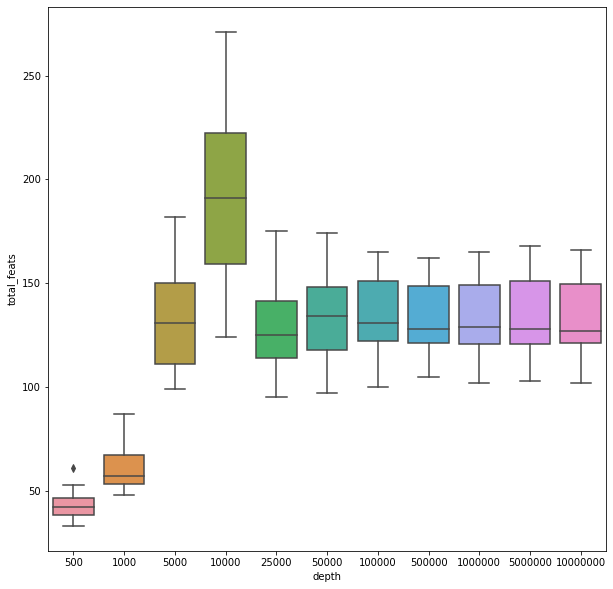

In [11]:
f = plt.figure(figsize=(10,10))
ax = sns.boxplot(data=combined_df, x='depth', y='total_feats')
f.show()

# Overlap + Correlation of Features At Varying Depths

In [12]:
depths_use = combined_df.sort_values('depth')['depth'].unique()
unique_samples = combined_df['run_acc'].unique()
ten_M_idx = (combined_df['depth'] == 10e6).to_numpy()
data_mat = get_matrix(combined_df)
data_mat.shape

(209, 6863)

In [13]:
stats_dict = {'depth': [], 'run_acc': [], 'jaccard': [], 'cor': [], 'feats_at_depth': [], 'feats_at_10M': [], 'union_feats': []}

for i in range(0, len(depths_use) - 1):
    depth_i = depths_use[i]
    depth_i_idx = (combined_df['depth'] == depth_i).to_numpy()
    for s in unique_samples:
        s_idx = (combined_df['run_acc'] == s).to_numpy()
        s_i_idx = np.logical_and(depth_i_idx, s_idx)
        if not np.sum(s_i_idx) == 1:
            assert False
        s_i_vals = data_mat[s_i_idx, :].flatten()
        # set nan values to 0
        s_i_vals[np.logical_not(s_i_vals > 0)] = 0.
        
        s_10M_idx = np.logical_and(ten_M_idx, s_idx)
        if not np.sum(s_10M_idx) == 1:
            assert False
        s_10M_vals = data_mat[s_10M_idx, :].flatten()
        s_10M_vals[np.logical_not(s_10M_vals > 0)] = 0.
        # calculate overlap with feats at given depth with feats at 10M reads
        s_i_feats = s_i_vals > 0
        s_10M_feats = s_10M_vals > 0
        s_i_overlap = jaccard(s_i_feats, s_10M_feats)
        # calculate correlation across union of nonzero features
        union_feats = np.logical_or(s_i_feats, s_10M_feats)
        s_i_cor, _ = pearsonr(s_i_vals[union_feats], s_10M_vals[union_feats])
        # store values
        stats_dict['depth'].append(depth_i)
        stats_dict['run_acc'].append(s)
        stats_dict['jaccard'].append(s_i_overlap)
        stats_dict['cor'].append(s_i_cor)
        stats_dict['feats_at_depth'].append(np.sum(s_i_feats))
        stats_dict['feats_at_10M'].append(np.sum(s_10M_feats))
        stats_dict['union_feats'].append(np.sum(union_feats))
        
stats_df = pd.DataFrame(stats_dict)        

In [14]:
stats_df

,depth,run_acc,jaccard,cor,feats_at_depth,feats_at_10M,union_feats
0,500,ERR2017411,0.669231,0.978173,44,129,130
1,500,ERR2017412,0.695652,0.889764,51,129,138
2,500,ERR2017413,0.696000,0.980036,41,122,125
3,500,ERR2017414,0.634146,0.992857,46,122,123
4,500,ERR2017415,0.685484,0.978223,40,123,124
...,...,...,...,...,...,...,...
185,5000000,ERR2017426,0.024390,0.999928,121,122,123
186,5000000,ERR2017427,0.016529,0.999997,120,120,121
187,5000000,ERR2017428,0.028846,0.999999,103,102,104
188,5000000,ERR2017429,0.018692,0.999987,106,106,107


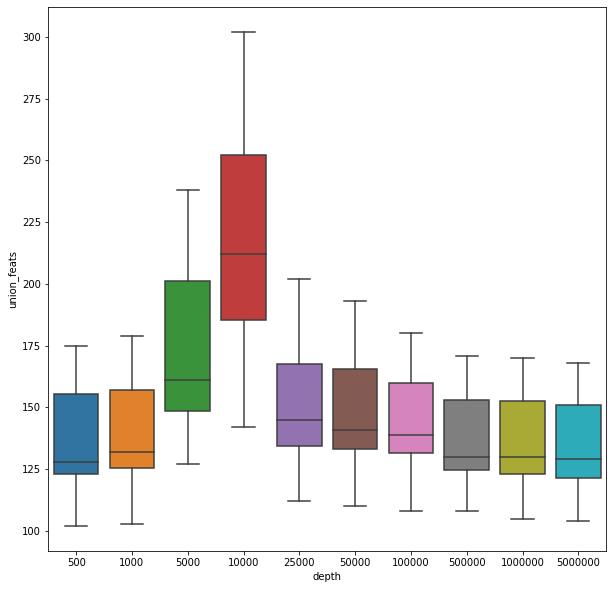

In [15]:
# size of union of nonzero features between 10 million read depth and other read depths
f = plt.figure(figsize=(10,10))
ax = sns.boxplot(data=stats_df, x='depth', y='union_feats')
f.show()

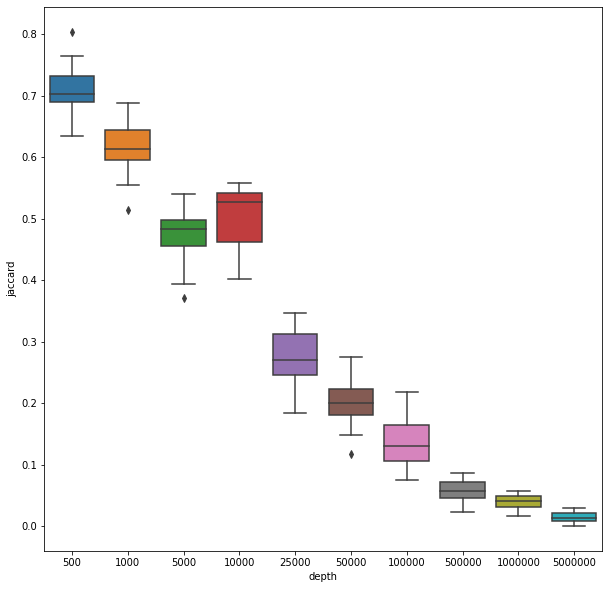

In [16]:
# jaccard distance of nonzero feature sets for depth of 10 million and other depths (other depth listed on x axis)
# 1.0 = no overlap, 0.0 = perfect overlap
f = plt.figure(figsize=(10,10))
ax = sns.boxplot(data=stats_df, x='depth', y='jaccard')
f.show()

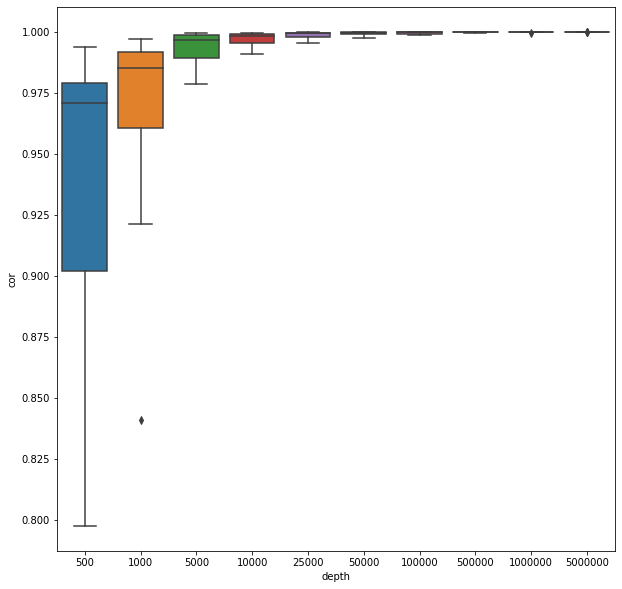

In [17]:
# correlation of union feature set for 10 million read depth and other read depths
f = plt.figure(figsize=(10,10))
ax = sns.boxplot(data=stats_df, x='depth', y='cor')
f.show()